<a href="https://colab.research.google.com/github/Maoherr/r-EAN-ML2-ActividadFinal/blob/main/EncuentroFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importar librerias necessarias
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping # Importar EarlyStopping
from sklearn.model_selection import train_test_split # Importar train_test_split
import matplotlib.pyplot as plt


# 1. Carga y preprocesamiento
* Leer el CSV con pandas.
* Limpiar texto (opcional: minúsculas, quitar signos, etc).
* Tokenización, vectorización (puede usarse Tokenizer de Keras)
* Padding para igualar longitud de secuencias.
* Convertir etiquetas a 0 (negativo) y 1 (positivo).







In [2]:
# 1. Cargar datos
df = pd.read_csv('comentarios.csv')
# Mostrar las primeras filas del archivo
print("Primeras filas del archivo:")
print(df.head())

# Mostrar información general del DataFrame
# Revisar el tipo de datos y si hay valores nulos.
print("\nInformación general:")
print(df.info())

# Mostrar estadísticas básicas (no aplican a texto, pero muestra el conteo de valores)
# Contar cuántos comentarios hay para cada tipo de sentimiento.
print("\nConteo de valores por etiqueta de sentimiento:")
print(df['sentimiento'].value_counts())

Primeras filas del archivo:
                                     comentario sentimiento
0         No me gustó la metodología utilizada.    negativo
1  Recomendaría este curso a otros estudiantes.    positivo
2          Hubo falta de claridad en los temas.    negativo
3          Hubo falta de claridad en los temas.    negativo
4            Los ejemplos eran poco relevantes.    negativo

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comentario   1000 non-null   object
 1   sentimiento  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB
None

Conteo de valores por etiqueta de sentimiento:
sentimiento
negativo    500
positivo    500
Name: count, dtype: int64


Cantidad de comentarios por clase:
sentimiento
negativo    500
positivo    500
Name: count, dtype: int64


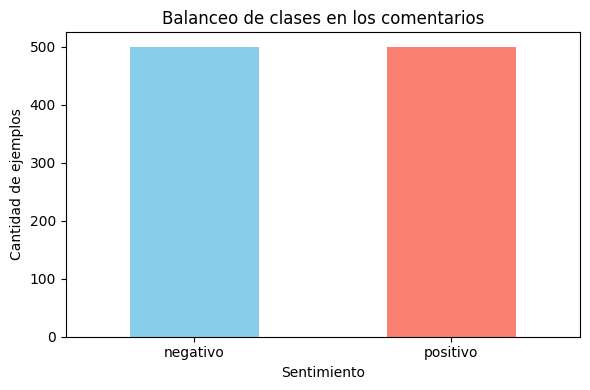

In [3]:
# Ver el Balanceo
# Contar la cantidad de ejemplos por clase
conteo = df['sentimiento'].value_counts()
print("Cantidad de comentarios por clase:")
print(conteo)

# Visualizar el balanceo de clases
plt.figure(figsize=(6,4))
conteo.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Balanceo de clases en los comentarios')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de ejemplos')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

2. Crear el Modelo

Dado que el problema es de clasificación de texto (sentimiento positivo/negativo), decidimos el siguiente flujo de procesamiento con Keras/Tensorflow:
*   Limpiar texto (opcional: minúsculas, quitar signos, etc).
*   Tokenización, vectorización (puede usarse Tokenizer de Keras).
*   Padding para igualar longitud de secuencias.
*   Convertir etiquetas a 0 (negativo) y 1 (positivo).




In [4]:
# 2. Preprocesamiento
comentarios = df['comentario'].astype(str).values
etiquetas = (df['sentimiento'] == 'positivo').astype(int).values

In [5]:
# 3. Tokenización
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(comentarios)
sequences = tokenizer.texts_to_sequences(comentarios)

MAX_LEN = 20 # Define MAX_LEN based on the desired padding length
padded = pad_sequences(sequences, padding='post', maxlen=MAX_LEN)

# Define MAX_VOCAB based on the tokenizer's vocabulary size (or num_words)
MAX_VOCAB = tokenizer.num_words

# Elección del Modelo
Se elige LSTM (Long Short-Term Memory) para el análisis del texto porque aprovecha la naturaleza secuencial del lenguaje, mientras que un MLP (Multi-Layer Perceptron) trata cada entrada como independiente y pierde el contexto, lo cual es crítico en análisis de sentimientos o clasificación de texto.

In [6]:
# 4. Definir arquitectura y contruir el modelo LSTM

# Entrada: Secuencia de enteros (palabras)
# Embedding Layer (convierte palabras en vectores)
# Capa LSTM o SimpleRNN (para capturar contexto/secuencia)
# Salida: Dense con activación sigmoide (clasificación binaria)

# 4. Definir arquitectura y contruir el modelo LSTM
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=64, input_length=MAX_LEN),
    LSTM(32, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 5. Dividir los datos preprocesados (padded y etiquetas) en conjuntos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(padded, etiquetas, test_size=0.2, random_state=42)

In [8]:
# 6. Entrenamiento del modelo
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.5071 - loss: 0.6939 - val_accuracy: 0.4688 - val_loss: 0.6919
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5615 - loss: 0.6796 - val_accuracy: 1.0000 - val_loss: 0.5434
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9517 - loss: 0.3708 - val_accuracy: 1.0000 - val_loss: 0.0554
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 1.0000 - loss: 0.0392 - val_accuracy: 1.0000 - val_loss: 0.0136
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 1.0000 - val_loss: 0.0070
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 1.0000 - v

In [9]:
# 7. Evaluación
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Precisión en test: {accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0019 
Precisión en test: 1.0000


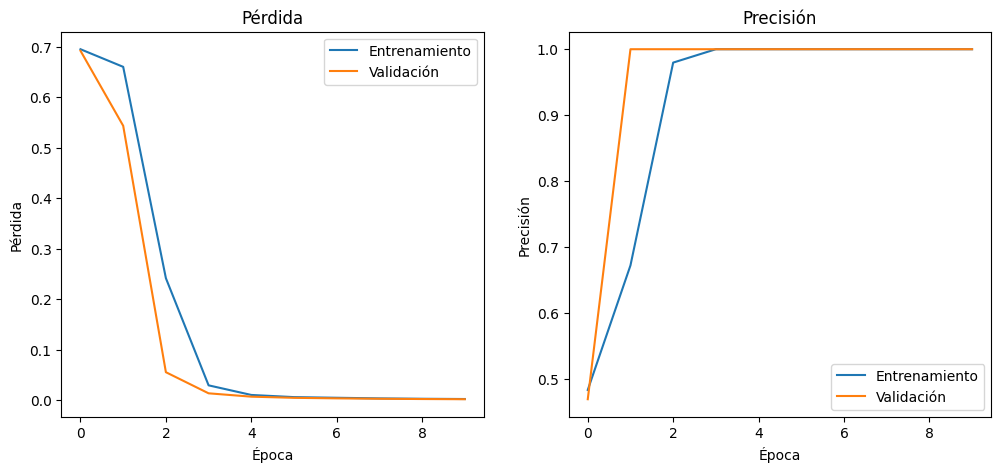

In [10]:
# Visualiza la pérdida y precisión en entrenamiento y validación
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()